<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Lecture 11: Individual mobility</h2>
<h3>IT University of Copenhagen, Spring 2022</h3>
<h3>Instructor: Michael Szell</h3>
</div>

# Source
This notebook was adapted from:
* sci-kit mobility tutorials: https://github.com/scikit-mobility/tutorials/tree/master/mda_masterbd2020

## 什么是 scikit-mobility？

一个分析<font color="red">*移动数据*</font>的库，适用于：

- **轨迹**由纬度/经度点组成（例如，GPS 数据）
- 地方之间运动的**通量**（例如，OD 矩阵）


In [5]:
# import the library
import skmob
import warnings
import geopandas as gpd
import pandas as pd
from skmob.tessellation import tilers
from skmob.utils import plot
import matplotlib.pyplot as plt
from tqdm import tqdm
from stats_utils import *

warnings.filterwarnings('ignore')
tess_style = {'color':'gray', 'fillColor':'gray', 'opacity':0.2}

scikit-mobility 提供了两个用户友好的数据结构，它们扩展了 *pandas* `DataFrame`：

- `TrajDataFrame` - 用于时空<font color="red">**trajectories**</font>
- `FlowDataFrame` - 用于 <font color="red">**fluxes**</font> 映射到曲面细分


### 您可以使用 scikit-mobility 做什么？

- 移动数据的**预处理**
- **衡量**个人和集体行为
- <font color="grey">**评估**隐私风险</font>
- <font color="grey">**预测**移民流</font>
- <font color="grey">**生成**合成轨迹</font>
    

## `TrajDataFrame`


每行描述轨迹的点并包含以下列：

- `lat` - 点的纬度
- `lng` - 点的经度
- `datetime` - 点的日期和时间

对于多用户数据集，有两个*可选*列：

- `uid` - 轨迹所属的用户标识符
- `tid` - 轨迹的标识符

可以从以下内容创建 TrajDataFrame：

- 一个 python 列表或 *numpy* 数组
- 一个 python 字典
- 一个 *pandas* `DataFrame`
- 一个文本文件

### 来自“List”

In [6]:
# From a list
data_list = [[1, 39.984094, 116.319236, '2008-10-23 13:53:05'],
             [1, 39.984198, 116.319322, '2008-10-23 13:53:06'],
             [1, 39.984224, 116.319402, '2008-10-23 13:53:11'],
             [1, 39.984211, 116.319389, '2008-10-23 13:53:16']]
data_list

[[1, 39.984094, 116.319236, '2008-10-23 13:53:05'],
 [1, 39.984198, 116.319322, '2008-10-23 13:53:06'],
 [1, 39.984224, 116.319402, '2008-10-23 13:53:11'],
 [1, 39.984211, 116.319389, '2008-10-23 13:53:16']]

我们必须使用参数“latitude”、“longitude”和“datetime”设置强制列的索引。

In [7]:
tdf = skmob.TrajDataFrame(data_list, 
                          latitude=1, longitude=2, 
                          datetime=3)
print(type(tdf))
tdf

<class 'skmob.core.trajectorydataframe.TrajDataFrame'>


,0,lat,lng,datetime
0,1,39.984094,116.319236,2008-10-23 13:53:05
1,1,39.984198,116.319322,2008-10-23 13:53:06
2,1,39.984224,116.319402,2008-10-23 13:53:11
3,1,39.984211,116.319389,2008-10-23 13:53:16


### 来自 `DataFrame`

In [8]:
# import the pandas library
import pandas as pd 
# build a dataframe from the 2D list
data_df = pd.DataFrame(data_list, 
                       columns=['user', 'latitude', 'lng', 'hour']) 

In [9]:
print(type(data_df)) # type of the structure
data_df.head() # head of the DataFrame

<class 'pandas.core.frame.DataFrame'>


,user,latitude,lng,hour
0,1,39.984094,116.319236,2008-10-23 13:53:05
1,1,39.984198,116.319322,2008-10-23 13:53:06
2,1,39.984224,116.319402,2008-10-23 13:53:11
3,1,39.984211,116.319389,2008-10-23 13:53:16


注意：
- `data_df` 中的列名称与所需名称不匹配
- 您必须使用参数 `latitude`、`longitude` 和 `datetime` 指定必填列的名称

In [10]:
# Create a TrajDataFrame from a DataFrame
tdf = skmob.TrajDataFrame(data_df, 
                          latitude='latitude', 
                          datetime='hour', 
                          user_id='user')

print(type(tdf))
tdf.head()

<class 'skmob.core.trajectorydataframe.TrajDataFrame'>


,uid,lat,lng,datetime
0,1,39.984094,116.319236,2008-10-23 13:53:05
1,1,39.984198,116.319322,2008-10-23 13:53:06
2,1,39.984224,116.319402,2008-10-23 13:53:11
3,1,39.984211,116.319389,2008-10-23 13:53:16


### 来自文本文件

`TrajDataFrame` 类有一个方法 `from_file` 从输入文本文件构造对象。

让我们尝试使用 <font color="red">**GeoLife**</font> 轨迹的子样本。 可以在[此处](https://www.microsoft.com/en-us/download/details.aspx?id=52367) 找到整个数据集。

In [11]:
# create a TrajDataFrame from a dataset of trajectories 
tdf = skmob.TrajDataFrame.from_file(
    'files/geolife_sample.txt.gz', sep=',')
print(type(tdf))

<class 'skmob.core.trajectorydataframe.TrajDataFrame'>


In [12]:
# explore the TrajDataFrame
tdf.head(5)

,lat,lng,datetime,uid
0,39.984094,116.319236,2008-10-23 05:53:05,1
1,39.984198,116.319322,2008-10-23 05:53:06,1
2,39.984224,116.319402,2008-10-23 05:53:11,1
3,39.984211,116.319389,2008-10-23 05:53:16,1
4,39.984217,116.319422,2008-10-23 05:53:21,1


### `TrajDataFrame` 的属性


- `crs`：坐标参考系统。 默认值：`epsg:4326`（纬度/经度）
- `parameters`：要添加尽可能多的附加属性的字典

In [13]:
tdf.crs

{'init': 'epsg:4326'}

In [14]:
tdf.parameters

{'from_file': 'files/geolife_sample.txt.gz'}

In [15]:
# add your own parameter
tdf.parameters['compress'] = {'thre': 10}
tdf.parameters

{'from_file': 'files/geolife_sample.txt.gz', 'compress': {'thre': 10}}

`TrajDataFrame` 的列有特定的类型

In [16]:
# In the DataFrame
print(type(data_df))
data_df.dtypes

<class 'pandas.core.frame.DataFrame'>


user          int64
latitude    float64
lng         float64
hour         object
dtype: object

In [17]:
print(type(tdf)) # In the TrajDataFrame
tdf.dtypes

<class 'skmob.core.trajectorydataframe.TrajDataFrame'>


lat                float64
lng                float64
datetime    datetime64[ns]
uid                  int64
dtype: object

In [18]:
tdf.lat.head()

0    39.984094
1    39.984198
2    39.984224
3    39.984211
4    39.984217
Name: lat, dtype: float64

### 写和读

要将 `TrajDataFrame` 写入/读取到文件中，scikit-mobility 提供了临时方法。

#### 将 `TrajDataFrame` 写入文件

- 包括 `parameters` 和 `crs` 属性
- 保留带有时间戳的列的“dtype”（虽然时区信息丢失）。

In [19]:
skmob.write(tdf, './tdf.json')

In [20]:
tdf.parameters

{'from_file': 'files/geolife_sample.txt.gz', 'compress': {'thre': 10}}

### 从 json 文件中读取 `TrajDataFrame`

In [21]:
# read the file written before
tdf2 = skmob.read('./tdf.json') 
tdf2[:4]

,lat,lng,datetime,uid
0,39.984094,116.319236,2008-10-23 05:53:05,1
1,39.984198,116.319322,2008-10-23 05:53:06,1
2,39.984224,116.319402,2008-10-23 05:53:11,1
3,39.984211,116.319389,2008-10-23 05:53:16,1


`dtype` 和 `parameters` 和 `crs` 属性被保留

In [22]:
print(tdf2.dtypes)
tdf2.parameters

lat                float64
lng                float64
datetime    datetime64[ns]
uid                  int64
dtype: object


{'from_file': 'files/geolife_sample.txt.gz', 'compress': {'thre': 10}}

### 绘制轨迹和流量

*scikit-mobility* 依赖于 *folium* 库来绘制：
- 轨迹
- 流量
- 镶嵌

In [23]:
tdf.plot_trajectory(zoom=12, weight=3, opacity=0.9, 
                    tiles='Stamen Toner', start_end_markers=True)

## `FlowDataFrame`

每行描述一个流程并包含以下列：

- `origin`：原始图块的 ID
- `destination`：目标图块的 ID
- `flow`：从`origin`到`destination`的人数

<!-- 注意：`FlowDataFrame` 是一种具有起点-终点矩阵的数据框方式。 -->

### 镶嵌
每个 `FlowDataFrame` 都与一个 <font color="red">**tessellation**</font> 相关联，即包含两列的 `GeoDataFrame`：
- `tile_ID`，一个位置的标识符
- `geometry`，位置的几何形状

### 创建一个“FlowDataFrame”

`FlowDataFrame` 可以通过以下方式创建：

- 一个 python 列表或一个 numpy 数组
- 一个 *pandas* `DataFrame`
- 一个 python 字典
- 一个文本文件

### 从一个文件

方法 `from_file` 从文本文件创建一个 `FlowDataFrame`，格式如下：
    
- `origin`, `destination`, `flow`, `datetime` (可选)

In [24]:
tessellation = gpd.GeoDataFrame.from_file(
    "files/NY_counties_2011.geojson") # load a tessellation

# create a FlowDataFrame from a file and a tessellation
fdf = skmob.FlowDataFrame.from_file(
    "files/NY_commuting_flows_2011.csv",
    tessellation=tessellation, tile_id='tile_id', sep=",")

In [25]:
fdf.head()

,flow,origin,destination
0,121606,36001,36001
1,5,36001,36005
2,29,36001,36007
3,11,36001,36017
4,30,36001,36019


In [26]:
fdf.dtypes

flow            int64
origin         object
destination    object
dtype: object

In [27]:
# The tessellation is an attribute of the FlowDataFrame
fdf.tessellation.head() 

,tile_ID,population,geometry
0,36019,81716,"POLYGON ((-74.00667 44.88602, -74.02739 44.995..."
1,36101,99145,"POLYGON ((-77.09975 42.27421, -77.09966 42.272..."
2,36107,50872,"POLYGON ((-76.25015 42.29668, -76.24914 42.302..."
3,36059,1346176,"POLYGON ((-73.70766 40.72783, -73.70027 40.739..."
4,36011,79693,"POLYGON ((-76.27907 42.78587, -76.27535 42.780..."


### 绘制tessellation

In [28]:
fdf.plot_tessellation(popup_features=['tile_ID', 'population']) 

### 绘制 flows

In [29]:
fdf.plot_flows(flow_color='green')

### 绘制 tessellation 与 flows

In [30]:
map_f = fdf.plot_tessellation(style_func_args=tess_style)
fdf[fdf['origin'] == '36061'].plot_flows(map_f=map_f, flow_exp=0., flow_popup=True)

# Mobility measures
- 我们加载用户在 **Brightkite** 上进行的 *checkins* 数据
- Brightkite 是一个基于位置的社交网络 (LBSN)
- 数据集可在 SNAP 网站上免费获得：https://snap.stanford.edu/data/loc-brightkite.html

In [31]:
# load the dataset using pandas
df = pd.read_csv("files/loc-brightkite_totalCheckins.txt.gz", sep='\t', header=0, nrows=500000, 
                 names=['user', 'check-in_time', "latitude", "longitude", 
                        "location id"])

# convert the pandas DataFrame into an skmob TrajDataFrame
tdf = skmob.TrajDataFrame(df, latitude='latitude', 
            longitude='longitude', datetime='check-in_time', user_id='user')
print(tdf.shape)
tdf.head()

(500000, 5)


,uid,datetime,lat,lng,location id
0,0,2010-10-16 06:02:04+00:00,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2
1,0,2010-10-16 03:48:54+00:00,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79
2,0,2010-10-14 18:25:51+00:00,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683
3,0,2010-10-14 00:21:47+00:00,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc
4,0,2010-10-13 23:31:51+00:00,39.752508,-104.996637,424eb3dd143292f9e013efa00486c907


In [32]:
print("number of users:\t", len(tdf.uid.unique()))
print("number of records:\t", len(tdf))

number of users:	 1231
number of records:	 500000


# Individual measures

- 根据<u>单个个体</u>的轨迹计算
- 量化标准*移动模式*
- 例子：
     - 回转半径
     - 跳跃长度
     - 最大距离
     - 个人移动网络

## 回转半径 $r_g$
个人行进的特征距离：

$$r_g = \sqrt{\frac{1}{N} \sum_{i=1}^N (\mathbf{r}_i - \mathbf{r}_{cm})^2}$$

$r_{cm}$ 是个人访问过的一组位置的*质心*的位置向量

In [33]:
from skmob.measures.individual import radius_of_gyration

In [34]:
rg_df = radius_of_gyration(tdf)

100%|██████████| 1231/1231 [00:01<00:00, 717.36it/s]


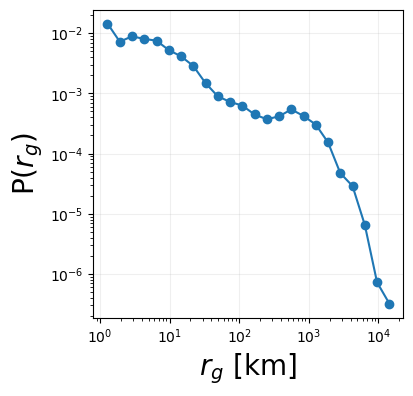

In [35]:
# let's plot the distribution of the radius of gyration
fig = plt.figure(figsize=(4, 4))
rg_list = list(rg_df.radius_of_gyration[rg_df.radius_of_gyration >= 1.0])
x, y = zip(*lbpdf(1.5, rg_list))
plt.plot(x, y, marker='o')
plt.xlabel('$r_g$ [km]', fontsize=20);plt.ylabel('P($r_g$)', fontsize=20)
plt.grid(alpha=0.2);
plt.loglog();
plt.show()

## 跳跃长度
- 跳跃长度是一个人连续两次访问之间的距离
- 给定一个“TrajDataFrame”，skmob 独立计算每个个体的长度
- 使用 `jump_lengths` 函数

In [36]:
from skmob.measures.individual import jump_lengths

In [37]:
jl_df = jump_lengths(tdf) # disable progress bar with show_progress=False
jl_df.head(4)

100%|██████████| 1231/1231 [00:01<00:00, 635.13it/s]


,uid,jump_lengths
0,0,"[19.64046732887831, 0.0, 0.0, 1.74343110103816..."
1,1,"[6.505330424378811, 46.754366003759536, 53.928..."
2,2,"[0.0, 0.0, 0.0, 0.0, 3.641009719594163, 0.0, 5..."
3,3,"[3861.270630079885, 4.061631313492122, 5.91632..."


In [38]:
# merge=True put all distances of the individuals into a single list
jl_list = jump_lengths(tdf, merge=True)
type(jl_list)

100%|██████████| 1231/1231 [00:02<00:00, 602.80it/s]


list

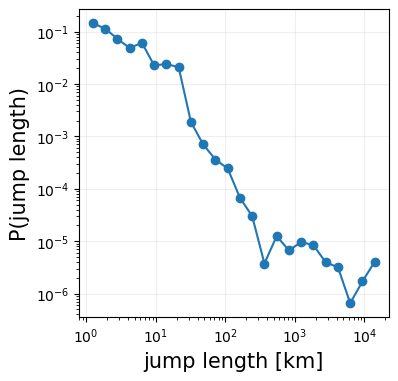

In [39]:
# let's plot the distribution of jump lengths
fig = plt.figure(figsize=(4, 4))
d_list = [dist for dist in jl_list[:10000] if dist >= 1]
x, y = zip(*lbpdf(1.5, d_list))
plt.plot(x, y, marker='o')
plt.xlabel('jump length [km]', fontsize=15);plt.ylabel('P(jump length)', fontsize=15)
plt.grid(alpha=0.2);plt.loglog();plt.show()

### 距离

- 每个人移动的最大距离 `maximum_distance`


In [40]:
from skmob.measures.individual import max_distance_from_home, distance_straight_line, maximum_distance

In [41]:
md_df = maximum_distance(tdf)
md_df.head()

100%|██████████| 1231/1231 [00:02<00:00, 512.70it/s]


,uid,maximum_distance
0,0,11294.436420
1,1,12804.895064
2,2,11286.745660
3,3,12803.259219
4,4,15511.927586


Text(0.5, 0, 'max')

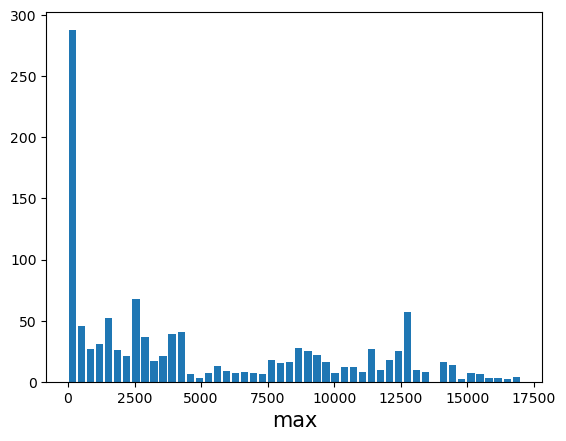

In [42]:
# let's plot the distribution
fig, ax1 = plt.subplots(1, 1)
ax1.hist(md_df.maximum_distance, bins=50, rwidth=0.8)
ax1.set_xlabel('max', fontsize=15)


## 个人移动网络
一个网络，其中：
- 节点代表个人访问过的位置
- 有向边表示个人所处位置之间的旅行

In [43]:
from skmob.measures.individual import individual_mobility_network

In [44]:
imn_df = individual_mobility_network(tdf)
imn_df.head()

100%|██████████| 1231/1231 [00:01<00:00, 619.78it/s]


,uid,lat_origin,lng_origin,lat_dest,lng_dest,n_trips
0,0,37.774929,-122.419415,37.600747,-122.382376,1
1,0,37.600747,-122.382376,37.615223,-122.389979,1
2,0,37.600747,-122.382376,37.580304,-122.343679,1
3,0,37.615223,-122.389979,39.878664,-104.682105,1
4,0,37.615223,-122.389979,37.580304,-122.343679,1


In [45]:
an_imn = imn_df[imn_df.uid == 2]
an_imn.sort_values(by='n_trips', ascending=False).head(5)

,uid,lat_origin,lng_origin,lat_dest,lng_dest,n_trips
1686,2,39.758302,-104.936129,39.802002,-105.095430,69
1452,2,39.802002,-105.095430,39.758302,-104.936129,59
1493,2,39.739154,-104.984703,39.802002,-105.095430,52
1446,2,39.802002,-105.095430,39.739154,-104.984703,51
1535,2,39.739154,-104.984703,39.818040,-105.081949,23


# Collective measures

- 根据<u>个人群体</u>的轨迹计算
- 量化标准*移动模式*
- 例子：
     - 每个时间单位的访问
     - 起点终点矩阵

## 每个地点的访问量

个人人口对某个地点的访问次数

In [46]:
from skmob.measures.collective import visits_per_location

In [47]:
vpl_df = visits_per_location(tdf)
vpl_df.head()

,lat,lng,n_visits
0,0.000000,0.000000,10378
1,39.739154,-104.984703,9958
2,40.014986,-105.270546,4548
3,37.774929,-122.419415,3615
4,40.714269,-74.005973,2881


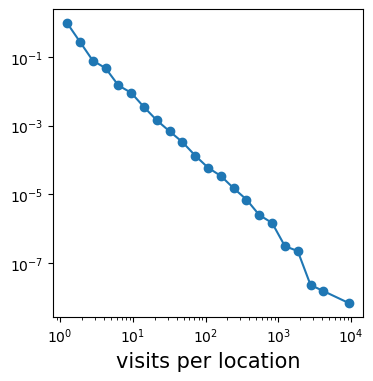

In [48]:
fig = plt.figure(figsize=(4, 4))
x, y = zip(*lbpdf(1.5, list(vpl_df.n_visits)))
plt.plot(x, y, marker='o')
plt.xlabel('visits per location', fontsize=15)
plt.loglog() 
plt.show()

### 可以使用 scikit-mobility 计算许多其他度量。 
#### Just check the documentation https://scikit-mobility.github.io/scikit-mobility/reference/measures.html